In [115]:
"""***This program evaluates MA Cross trading strategy using Python***

    -tvDatafeed package is used to get data from TradingView.
    -tvDatafeed uses python 3.8, errors occur v3.9
    -manual login to tradingview is required, auto_login feature has some issues
    - EMAs used are 20-EMA and 50-EMA
    
"""


# import packages to communicate with tradingview and get historical data of a stock/currency
from tvDatafeed import TvDatafeed, Interval

#import numpy, pandas and matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math


In [116]:
# use tradingview credentials to login
username = 'testherald123@gmail.com'
password = '#testHerald123'

# opening tradingview sign-in page to manual login, select sign-in with Google account and use the credentials above
tv = TvDatafeed(auto_login=False)

In [117]:
"""
***Getting data from Tradingview***
"""

# get stock/currency data
data = tv.get_hist("BTCUSDTPERP", "BINANCE", n_bars=5000)

# dropping columns that are not needed
data = data.drop(columns=["high","low"])

print(data.head())
print(data.info())

                                  symbol      open     close     volume
datetime                                                               
2019-09-08 08:00:00  BINANCE:BTCUSDTPERP  10000.00  10391.63   3096.291
2019-09-09 08:00:00  BINANCE:BTCUSDTPERP  10316.62  10307.00  14824.373
2019-09-10 08:00:00  BINANCE:BTCUSDTPERP  10307.00  10102.02   9068.955
2019-09-11 08:00:00  BINANCE:BTCUSDTPERP  10094.27  10159.55  10897.922
2019-09-12 08:00:00  BINANCE:BTCUSDTPERP  10163.06  10415.13  15609.634
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 858 entries, 2019-09-08 08:00:00 to 2022-01-12 08:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  858 non-null    object 
 1   open    858 non-null    float64
 2   close   858 non-null    float64
 3   volume  858 non-null    float64
dtypes: float64(3), object(1)
memory usage: 33.5+ KB
None


<AxesSubplot:title={'center':'Daily BTCUSDTPERP Data'}, xlabel='datetime'>

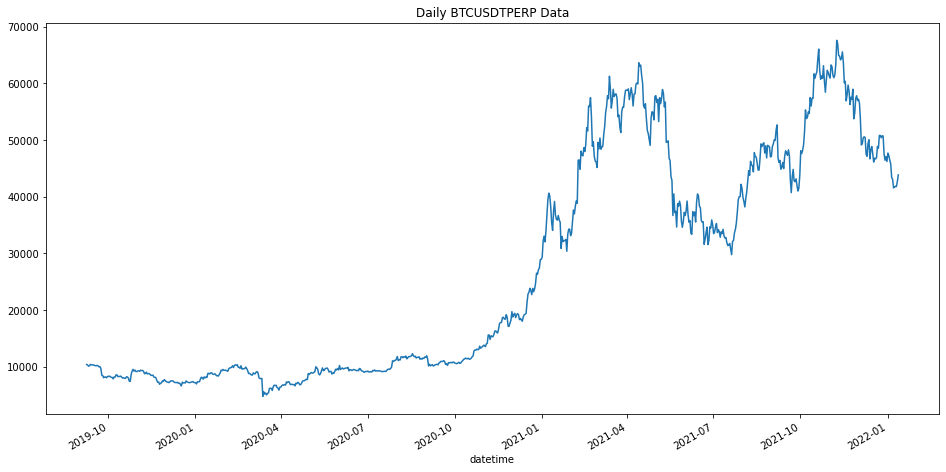

In [118]:
# plot data from tradingview based on the close price
data.close.plot(title= "Daily BTCUSDTPERP Data", figsize=(16,8))

In [119]:
""" 
***Manipulate data to create 20 EMA and 50 EMA.
"""
# define window durations for calculating MAs
fast_w = 20
slow_w = 50


# modifying price data using SMA so that there will bo no calculations for the first n-days depending on the window defined
sma_fast = data["close"].rolling(window=fast_w).mean()
mod_price_fast = data["close"].copy()
mod_price_fast.iloc[0:fast_w] = sma_fast[0:fast_w]

sma_slow = data["close"].rolling(window=slow_w).mean()
mod_price_slow = data["close"].copy()
mod_price_slow.iloc[0:slow_w] = sma_slow[0:slow_w]

# calculating fast EMA
fast_ema = np.round(mod_price_fast.ewm(span=fast_w, adjust=False, ignore_na=True).mean(), decimals=2)


# calculating slow EMA
slow_ema = np.round(mod_price_slow.ewm(span=slow_w, adjust=False, ignore_na=True).mean(), decimals=2)

# adding fast_ema and slow_ema to our dataframe
data[f"EMA_{fast_w}"] = fast_ema
data[f"EMA_{slow_w}"] = slow_ema

# check if corresponds to tradingview ema values

#print(data[f"EMA_{fast_w}"].head(30))
#print(data[f"EMA_{slow_w}"].iloc[30:60])

# plot the stock/currency price and the EMAs

#plt.figure(figsize=(16,10))
#plt.plot(data["close"], label="Price", color="lightgray")
#plt.plot(data[f"EMA_{fast_w}"], label=f"EMA_{fast_w}", color="orange")
#plt.plot(data[f"EMA_{slow_w}"], label=f"EMA_{slow_w}", color="blue")
#plt.legend(loc="upper left")

#plt.show()




In [125]:
""" 
***Create signals to open and close a long positions as well as a shor positions.

"""
# lists to hold the values of prices where we execute a long or short position 
open_long = []
open_short = []

# signals to exectute a long or short position
trigger = 0

# intizialize trigger value based on the EMA values before their first crossing
first_slow_ema = data[f"EMA_{slow_w}"].iloc[slow_w - 1]
fast_ema_at_first_slow_ema = data[f"EMA_{fast_w}"].iloc[slow_w - 1]

# trigger to short
if first_slow_ema > fast_ema_at_first_slow_ema:
    trigger = -1 

# trigger to long
else: 
    trigger = 1

# algorithm that creates signals for long and short position. 
# If fast EMA crosses above slow EMA, it executes a long position and "open_long" list will be appended by the closing price at that time.
# If slow EMA crosses above fast EMA, it executes a short position and "open_short" list will be appended by the closing price at that time.

for x in range(len(data)):
    
    # append open_long list to create a long position signal
    if data[f"EMA_{fast_w}"].iloc[x] > data[f"EMA_{slow_w}"].iloc[x] and trigger == -1:
        open_long.append(data["close"].iloc[x])
        open_short.append(float("NaN"))
        trigger = 1
    
    # append open_short list to create a short position signal
    elif data[f"EMA_{fast_w}"].iloc[x] < data[f"EMA_{slow_w}"].iloc[x] and trigger == 1:
        open_long.append(float("NaN"))
        open_short.append(data["close"].iloc[x])
        trigger = -1
        
    else:
        open_long.append(float("NaN"))
        open_short.append(float("NaN"))
        
# adding the long and short positions taken to our dataframe
# when a short position is added, we close the previous long position and vice versa

data["open long"] = open_long
data["close long"] = open_short.copy()

data["open short"] = open_short

# close_short is a modified open_long list where the first long position is removed.
index_positions = []

for x in range(len(open_long)):
    if math.isnan(open_long[x]) :
        continue
        
    else:
        index_positions.append(x)

close_short = open_long.copy()
close_short[index_positions[0]] = float("NaN")

data["close short"] = close_short

print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 858 entries, 2019-09-08 08:00:00 to 2022-01-12 08:00:00
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       858 non-null    object 
 1   open         858 non-null    float64
 2   close        858 non-null    float64
 3   volume       858 non-null    float64
 4   EMA_20       839 non-null    float64
 5   EMA_50       809 non-null    float64
 6   open long    5 non-null      float64
 7   close long   5 non-null      float64
 8   open short   5 non-null      float64
 9   close short  4 non-null      float64
dtypes: float64(9), object(1)
memory usage: 73.7+ KB
None


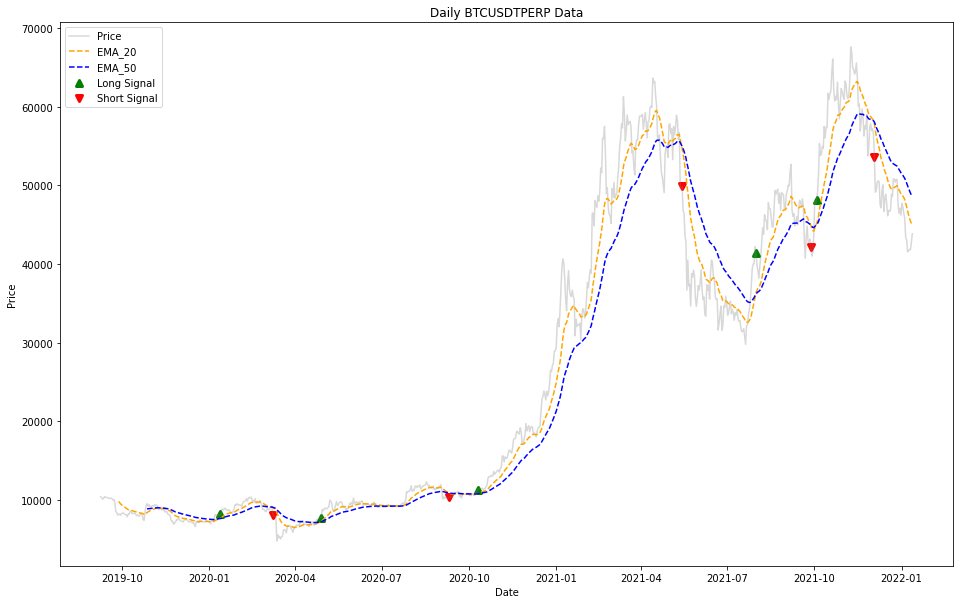

In [136]:
""" 
***Plotting the long positions the algorithm has executed

"""
plt.figure(figsize=(16,10))
plt.plot(data["close"], label="Price", color="gray", alpha=0.3)
plt.plot(data[f"EMA_{fast_w}"], label=f"EMA_{fast_w}", color="orange", linestyle="--")
plt.plot(data[f"EMA_{slow_w}"], label=f"EMA_{slow_w}", color="blue", linestyle="--")
plt.scatter(data.index, data["open long"], label="Long Signal", marker="^", color="green", lw=3)
plt.scatter(data.index, data["open short"], label="Short Signal", marker="v", color="red", lw=3)
plt.title("Daily BTCUSDTPERP Data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left")

plt.show()

In [195]:
""" 
***Computing the statistics of our trades

"""
# Creating a new dataframe for our trades
trades = pd.DataFrame()

#list to initially hold values to fill out "trades" dataframe
position = []
entry_time = []
exit_time = []
entry_price = []
exit_price = []

# getting data from Long Trades using "open long" and "close long" from "data" dataframe.
for x in range(len(data)):
    
    if math.isnan(data["open long"].iloc[x]) == False:
        position.append("Long")
        entry_time.append(data.index[x])
        entry_price.append(data["open long"].iloc[x])
        
    elif math.isnan(data["close long"].iloc[x]) == False: 
        exit_time.append(data.index[x])
        exit_price.append(data["close long"].iloc[x])
    
    else: 
        continue
        
# getting data from Short Trades using "open short" and "close short" from "data" dataframe.
for x in range(len(data)):
    
    if math.isnan(data["open short"].iloc[x]) == False:
        position.append("Short")
        entry_time.append(data.index[x])
        entry_price.append(data["open short"].iloc[x])
        
    elif math.isnan(data["close short"].iloc[x]) == False: 
        exit_time.append(data.index[x])
        exit_price.append(data["close short"].iloc[x])
    
    else: 
        continue        

# assign NaN values to trades that are not yet closed
if entry_time.index != exit_time.index:
    exit_time.append(float("NaN"))
    exit_price.append(float("NaN"))
        
        
# assign lists to "trades" dataframe
trades["position"] = position
trades["entry time"] = entry_time
trades["exit time"] = exit_time
trades["entry price"] = entry_price
trades["exit price"] = exit_price

# Calulating number of candles from entry to exit
no_of_candles = trades["exit time"] - trades["entry time"]       
trades["no. of candles"] = no_of_candles.dt.days

# Calculating & Gain or loss
pnl = []

for x in range(len(trades)):
    
    if trades["position"].iloc[x] == "Long":
        
        profit_perc = 100*((trades["exit price"].iloc[x] - trades["entry price"].iloc[x])/trades["entry price"].iloc[x])
        pnl.append(np.round(profit_perc, decimals=2))
       
        
    else:
        
        profit_perc = -100*((trades["exit price"].iloc[x] - trades["entry price"].iloc[x])/trades["entry price"].iloc[x])
        pnl.append(np.round(profit_perc, decimals=2))
        
trades["PNL %"] = pnl

print(trades.sort_values("exit time"))
    

 

  position          entry time           exit time  entry price  exit price  \
0     Long 2020-01-12 08:00:00 2020-03-08 08:00:00      8186.70     8038.46   
5    Short 2020-03-08 08:00:00 2020-04-28 08:00:00      8038.46     7735.75   
1     Long 2020-04-28 08:00:00 2020-09-10 08:00:00      7735.75    10335.91   
6    Short 2020-09-10 08:00:00 2020-10-10 08:00:00     10335.91    11294.79   
2     Long 2020-10-10 08:00:00 2021-05-14 08:00:00     11294.79    49873.27   
7    Short 2021-05-14 08:00:00 2021-07-31 08:00:00     49873.27    41448.11   
3     Long 2021-07-31 08:00:00 2021-09-27 08:00:00     41448.11    42122.69   
8    Short 2021-09-27 08:00:00 2021-10-03 08:00:00     42122.69    48187.30   
4     Long 2021-10-03 08:00:00 2021-12-03 08:00:00     48187.30    53612.00   
9    Short 2021-12-03 08:00:00                 NaT     53612.00         NaN   

   no. of candles   PNL %  
0            56.0   -1.81  
5            51.0    3.77  
1           135.0   33.61  
6            30.0 